<a href="https://colab.research.google.com/github/Fuadsadik21/Empirical-Showdown-Frequentist-vs-Bayesian/blob/main/02_Frequentist_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Frequentist_Baseline**
> This notebook will focus purely on building, tuning, and evaluating the **standard (frequentist)** Logistic Regression model.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, log_loss, brier_score_loss,
                             RocCurveDisplay)

# For saving the model
import joblib

print("All libraries imported successfully!")

All libraries imported successfully!


### Load the CLEANED Dataset

In [2]:
# We are using the cleaned data we saved from the previous notebook
df_clean = pd.read_csv('https://raw.githubusercontent.com/Fuadsadik21/Empirical-Showdown-Frequentist-vs-Bayesian/refs/heads/main/data/diabetes_clean.csv')

print("Cleaned dataset loaded successfully!")
print(f"Dataset Shape: {df_clean.shape}")
df_clean.head()

Cleaned dataset loaded successfully!
Dataset Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.00000,155.548223,33.6,0.627,50,1
1,1,85.0,66.0,29.00000,155.548223,26.6,0.351,31,0
2,8,183.0,64.0,29.15342,155.548223,23.3,0.672,32,1
3,1,89.0,66.0,23.00000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.00000,168.000000,43.1,2.288,33,1


### Prepare Data for Modeling

In [3]:
# Separate Features (X) and Target (y)
X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']

# Perform the Train-Test Split (use same random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preparation complete!")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

Data preparation complete!
Training set shape: (614, 8)
Test set shape: (154, 8)


**Observations on Data Preparation:**
* Features (X) and target (y) were successfully separated.
* The data was split into training (80%) and testing (20%) sets using `stratify=y` to maintain the proportion of the target variable in both sets.
* Features were standardized using `StandardScaler`, which is important for algorithms sensitive to the scale of input features like Logistic Regression.
* The shapes of the resulting training and testing sets are as expected.

### Train a Default Logistic Regression Model (Baseline)

In [4]:
# Let's first see how a model with default settings performs
base_model = LogisticRegression(random_state=42, max_iter=1000)
base_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_base = base_model.predict(X_test_scaled)
y_pred_proba_base = base_model.predict_proba(X_test_scaled)

# Evaluate the base model
base_accuracy = accuracy_score(y_test, y_pred_base)
base_auc = roc_auc_score(y_test, y_pred_proba_base[:, 1])
base_log_loss = log_loss(y_test, y_pred_proba_base)
base_brier = brier_score_loss(y_test, y_pred_proba_base[:, 1])

print("=== DEFAULT MODEL PERFORMANCE ===")
print(f"Accuracy: {base_accuracy:.4f}")
print(f"AUC-ROC: {base_auc:.4f}")
print(f"Log Loss: {base_log_loss:.4f}")
print(f"Brier Score: {base_brier:.4f}")

=== DEFAULT MODEL PERFORMANCE ===
Accuracy: 0.6948
AUC-ROC: 0.8117
Log Loss: 0.5152
Brier Score: 0.1758


**Observations on Default Model Performance:**
* The default Logistic Regression model provides a baseline performance.
* The initial metrics (Accuracy, AUC-ROC, Log Loss, Brier Score) indicate a reasonable starting point, but there is room for improvement.
* The AUC-ROC of 0.8117 suggests the model has a good ability to distinguish between the two classes.

### Hyperparameter Tuning with GridSearch

In [5]:
# Define the parameter grid to search. 'C' is the inverse of regularization strength.
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Create the model. We use 'liblinear' solver as it's good for smaller datasets.
model = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')

# Set up GridSearchCV. We use 'neg_log_loss' as our scoring metric to find the best probabilistic model.
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_log_loss', refit=True, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and best score
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best cross-validation score (Negative Log Loss): {grid_search.best_score_:.4f}")

# Get the best model from the grid search
best_model = grid_search.best_estimator_

Best hyperparameters: {'C': 1}
Best cross-validation score (Negative Log Loss): -0.4674


**Observations on Hyperparameter Tuning:**
* GridSearchCV was used to find the optimal 'C' parameter for the Logistic Regression model.
* 'neg_log_loss' was chosen as the scoring metric, which is appropriate for evaluating the probabilistic predictions of the model.
* The best 'C' value found was 1, resulting in a best cross-validation negative log loss of -0.4674. This suggests this 'C' value minimizes the log loss on the training data through cross-validation.
* The `liblinear` solver was used, which is suitable for smaller datasets and the L2 regularization implied by the 'C' parameter.

### Evaluate the Tuned Model on the Test Set

In [6]:
# This is our final, tuned frequentist model
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)

# Calculate all important metrics
freq_accuracy = accuracy_score(y_test, y_pred)
freq_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
freq_log_loss = log_loss(y_test, y_pred_proba)
freq_brier = brier_score_loss(y_test, y_pred_proba[:, 1])

print("=== TUNED MODEL PERFORMANCE ===")
print(f"Accuracy: {freq_accuracy:.4f}")
print(f"AUC-ROC: {freq_auc:.4f}")
print(f"Log Loss: {freq_log_loss:.4f}")
print(f"Brier Score: {freq_brier:.4f}")

# Generate a classification report
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=['Non-Diabetic', 'Diabetic']))

=== TUNED MODEL PERFORMANCE ===
Accuracy: 0.6948
AUC-ROC: 0.8119
Log Loss: 0.5150
Brier Score: 0.1757

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

Non-Diabetic       0.74      0.81      0.78       100
    Diabetic       0.58      0.48      0.53        54

    accuracy                           0.69       154
   macro avg       0.66      0.65      0.65       154
weighted avg       0.69      0.69      0.69       154



**Observations on Tuned Model Performance:**
* The tuned model with C=1 achieved similar performance metrics (Accuracy, AUC-ROC, Log Loss, Brier Score) as the default model.
* The classification report provides a breakdown of precision, recall, and f1-score for both classes, showing that the model performs better at identifying Non-Diabetic cases (higher precision, recall, and f1-score) than Diabetic cases.

### Visualize Results

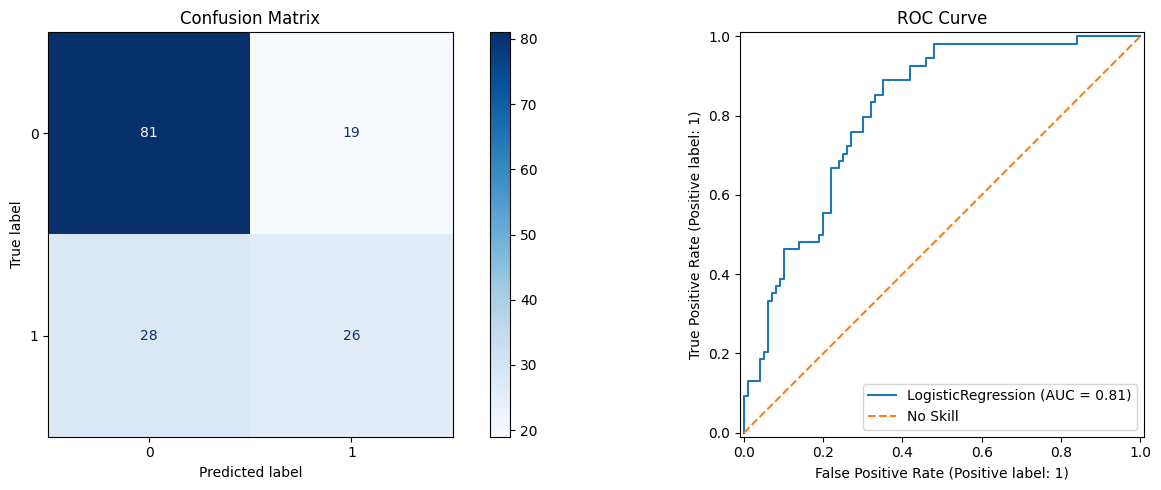

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix')

# 2. ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=axes[1])
axes[1].plot([0, 1], [0, 1], linestyle='--', label='No Skill')
axes[1].set_title('ROC Curve')
axes[1].legend()

plt.tight_layout()
plt.show()

**Observations on Visualizations:**
* The confusion matrix clearly shows the number of true positives, true negatives, false positives, and false negatives. It reinforces that the model has more difficulty correctly identifying diabetic cases (higher false negatives).
* The ROC curve illustrates the model's ability to discriminate between the two classes across different probability thresholds. The AUC of 0.81 is a good indicator of this discriminative power.

### Save Results and Model for Future Comparison

In [9]:
# Create a dictionary to store all results
frequentist_results = {
    'Accuracy': freq_accuracy,
    'AUC-ROC': freq_auc,
    'Log Loss': freq_log_loss,
    'Brier Score': freq_brier
}

# Create directories if they don't exist
import os
os.makedirs('results', exist_ok=True)
os.makedirs('models', exist_ok=True)

# Save the results to a file (for later comparison with Bayesian model)
import json
with open('results/frequentist_results.json', 'w') as f:
    json.dump(frequentist_results, f, indent=4)

# Save the trained model and the scaler
joblib.dump(best_model, 'models/frequentist_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')

print("Results and model saved successfully!")
print("Frequentist Results:", frequentist_results)

Results and model saved successfully!
Frequentist Results: {'Accuracy': 0.6948051948051948, 'AUC-ROC': np.float64(0.8118518518518519), 'Log Loss': 0.5150423729417748, 'Brier Score': np.float64(0.1756515675862772)}
